# SnS Solar Cell Example
This example is meant to follow the analysis done in [this paper](https://www.sciencedirect.com/science/article/pii/S254243511730096X), albeit at a lower resolution to demonstrate one level of grid subdivision as well as make it tractable to run in a few minutes on a personal computer.

## Introduction
In this example, we're using temperature- and light-intensity-dependent current-voltage measurements ($J(V,T,i)$) of a tin monosulfide (SnS) solar cell to fit four properties of the material and interfaces:

1. The band offset between the SnS and the Zn(O,S) buffer layer.
2. The surface recombination velocity at the SnS/Zn(O,S) interace.
3. The minority carrier (hole) mobility in the SnS absorber.
4. The minority carrier lifetime in the SnS absorber.

We use [SCAPS](http://scaps.elis.ugent.be) for our device model, and simulations have been precomputed and stored in this example folder. One subtlety is that three out of the four parameters above are not directly input into SCAPS but rather related to other input parameters, so to get the PMF over the variables of interest we'll have to transform the variables.

In [1]:
# import some code that we'll need
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
from helper_fcns import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
m = bym.Model(obs_data_path='obs_data.h5', model_data_path='SCAPS_data_sparse.h5', output_var='J', 
              ec_x_var='V', calc_model_unc=True, model_unc_factor=0.2, keep_all=True)
m.set_param_units('V', 'V')
m.set_param_units('T', 'K')
m.set_param_units('J', 'mA/cm^2')
m.set_param_units('EA', 'eV')
m.set_param_units('Nt_i', 'cm^-2')
m.set_param_units('Nt_SnS', 'cm^-3')
m.set_param_units('mu', 'cm^2/Vs')

Adding the variable V to the list of experimental conditions and setting it as the x-axis variable for plotting.
['T', 'ill', 'V', 'J', 'uncertainty']
Determining experimental conditions from observed data...
Identified experimental conditions as ['V', 'T', 'ill']. If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.
Determining fitting parameters from modeled data...
Setting min_width automatically for EA.
Setting min_width automatically for Nt_i.
Setting min_width automatically for mu.
Setting min_width automatically for Nt_SnS.
Found fitting parameters: ['EA', 'Nt_i', 'mu', 'Nt_SnS']
Rounding model data...


In [3]:
m.run(min_num_pts=len(m.obs_data),th_pm=0.9)

Did a total of 114 runs to use a total of 120 observations.

An average of 126 / 192 probability points had larger model uncertainty than experimental uncertainty during this run.


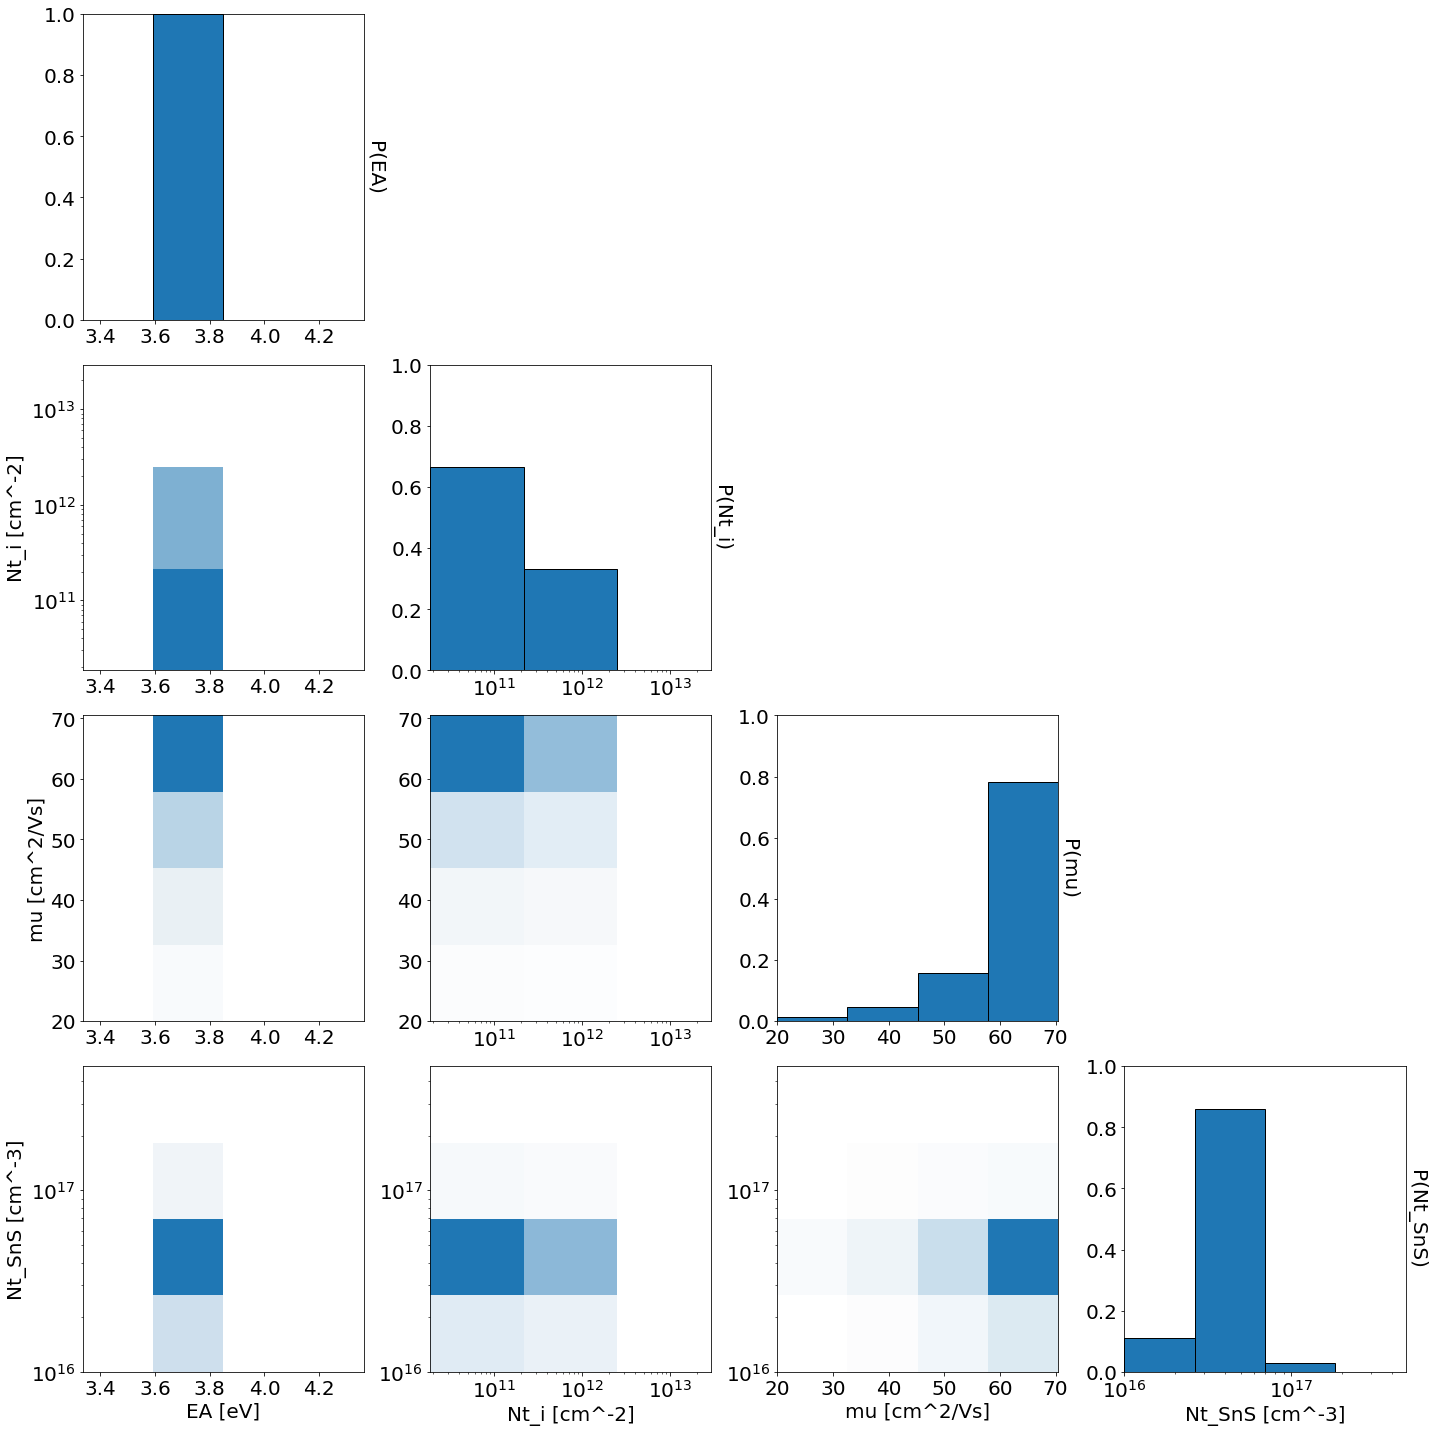

In [4]:
m.visualize_probs()

In [5]:
m.subdivide()

20 box(es) with probability > 0.001 and 122 neighboring boxes subdivided!
Overwriting metadata for fitting parameter EA with new info.
Overwriting metadata for fitting parameter Nt_i with new info.
Overwriting metadata for fitting parameter mu with new info.
Overwriting metadata for fitting parameter Nt_SnS with new info.
New model points to simulate are saved in the file new_sim_points_1.h5.


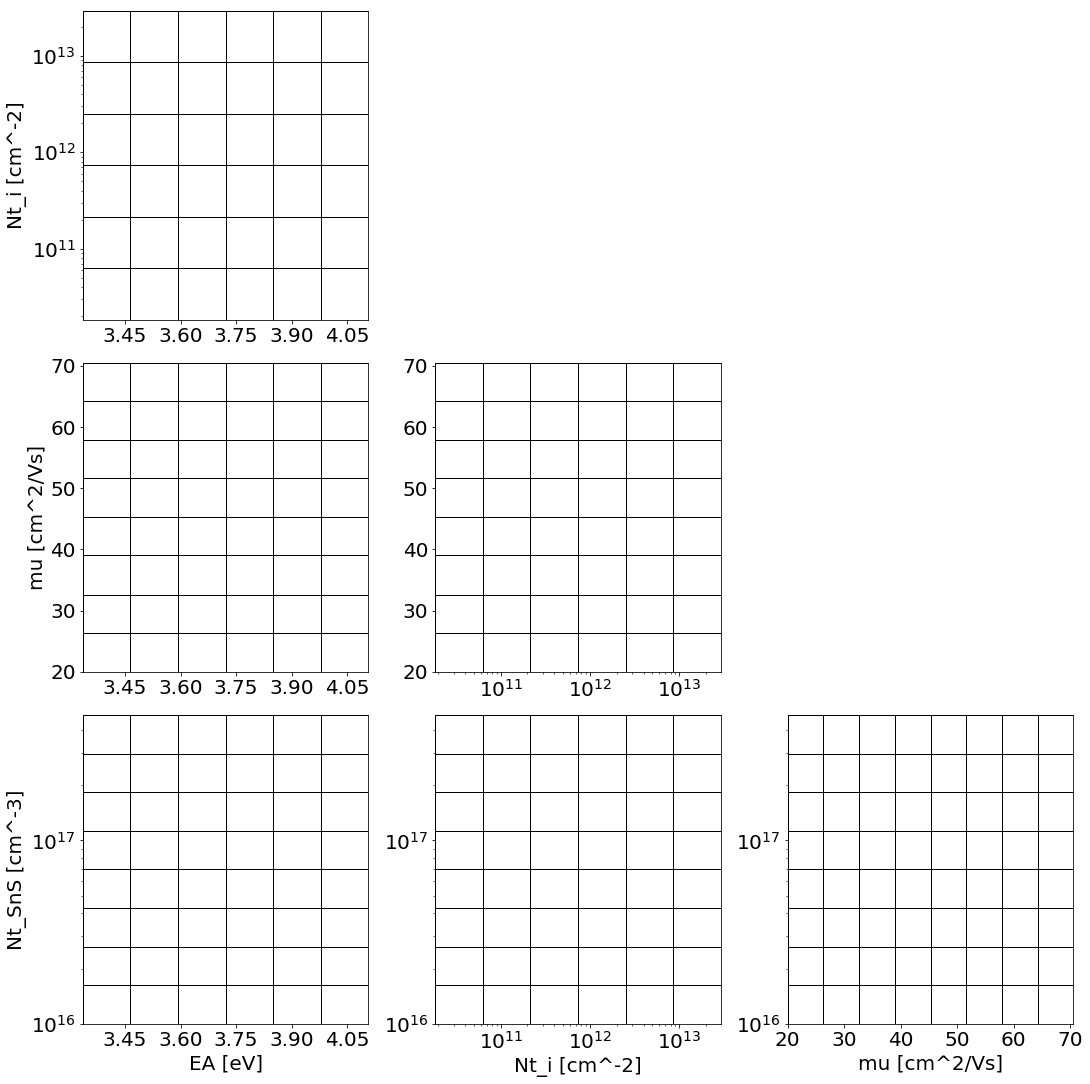

In [6]:
m.visualize_grid()

In [7]:
get_new_data(m, 'SCAPS_data_less_sparse.h5', 'new_sim_points_1.h5', 'new_sim_data.h5')
m.attach_model(mode='file', model_data_path='new_sim_data.h5', calc_model_unc=True)

Rounding model data...


In [8]:
m.run(min_num_pts=len(m.obs_data),th_pv=0.01,th_pm=0.99)

Used all the observed data! Last PMF to go into average may have been further from threshold condition.
Did a total of 1 runs to use a total of 120 observations.

An average of 1203 / 2272 probability points had larger model uncertainty than experimental uncertainty during this run.


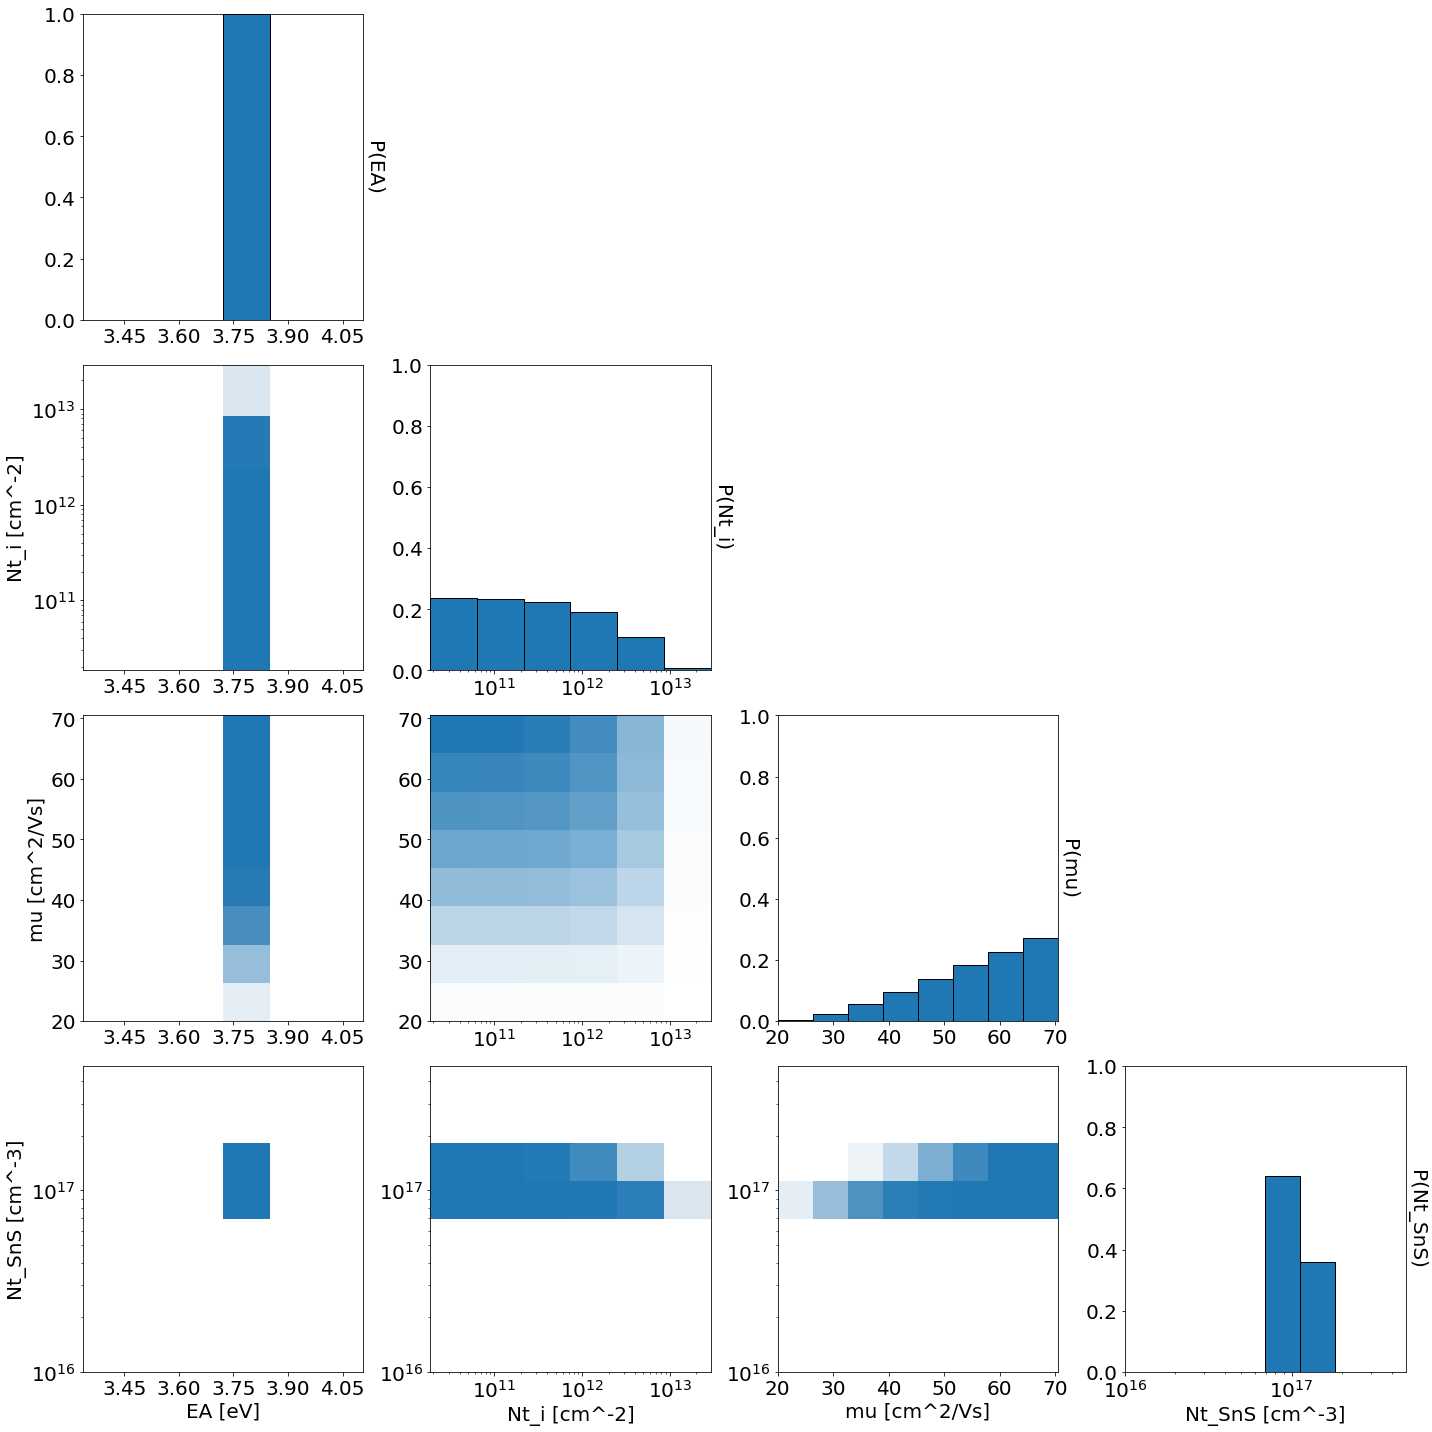

In [9]:
m.visualize_probs()